In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import math

class Mesh2D:
    def __init__(self, domain=((0, 1), (0, 1))):
        self.xmin, self.xmax = domain[0]
        self.ymin, self.ymax = domain[1]
        self.points = None
        self.tri = None
        self.k = None
        self.nx = None
        self.ny = None
        self.vertical_lines = []
        self.horizontal_lines = []
        self.primal_points = []
        self.dual_points = []

    def _factor_k(self, k):
        # Find best pair (nx, ny) such that nx * ny = k and is close to square
        for i in range(int(math.sqrt(k)), 0, -1):
            if k % i == 0:
                return i, k // i
        return 1, k

    def get_points(self, n, manual_points=None, ordered=False, add_border_points=True, k=None):
        if manual_points is not None:
            self.points = np.array(manual_points)
        elif ordered:
            side = int(np.sqrt(n))
            x = np.linspace(self.xmin, self.xmax, side)
            y = np.linspace(self.ymin, self.ymax, side)
            xx, yy = np.meshgrid(x, y)
            self.points = np.vstack([xx.ravel(), yy.ravel()]).T
        else:
            x = np.random.uniform(self.xmin, self.xmax, n)
            y = np.random.uniform(self.ymin, self.ymax, n)
            self.points = np.vstack((x, y)).T

            if add_border_points and k is not None:
                nx, ny = self._factor_k(k)
                self.nx, self.ny = nx, ny
                vx = [self.xmin + i * (self.xmax - self.xmin) / nx for i in range(1, nx)]
                hy = [self.ymin + i * (self.ymax - self.ymin) / ny for i in range(1, ny)]

                extra = []

                # Points on vertical borders
                for x_line in vx:
                    for _ in range(3):
                        y_val = np.random.uniform(self.ymin, self.ymax)
                        extra.append([x_line, y_val])

                # Points on horizontal borders
                for y_line in hy:
                    for _ in range(3):
                        x_val = np.random.uniform(self.xmin, self.xmax)
                        extra.append([x_val, y_line])

                # Points at intersections (primal candidates)
                for x_line in vx:
                    for y_line in hy:
                        extra.append([x_line, y_line])

                self.points = np.vstack((self.points, np.array(extra)))

    def triangulate(self):
        self.tri = Delaunay(self.points)

    def plot_triangulation(self):
        plt.figure(figsize=(6, 6))
        plt.triplot(self.points[:, 0], self.points[:, 1], self.tri.simplices.copy(), color='gray')
        plt.plot(self.points[:, 0], self.points[:, 1], 'ko', markersize=3)
        plt.title('Triangulation')
        plt.axis('equal')
        plt.show()

    def divide_domain(self, k):
        self.k = k
        self.nx, self.ny = self._factor_k(k)
        self.vertical_lines = []
        self.horizontal_lines = []
        self.primal_points = []
        self.dual_points = []

        vx = [self.xmin + i * (self.xmax - self.xmin) / self.nx for i in range(1, self.nx)]
        hy = [self.ymin + i * (self.ymax - self.ymin) / self.ny for i in range(1, self.ny)]

        for x in vx:
            self.vertical_lines.append(((x, self.ymin), (x, self.ymax)))
        for y in hy:
            self.horizontal_lines.append(((self.xmin, y), (self.xmax, y)))

        tolerance = 1e-6
        primal = []
        dual = []

        for point in self.points:
            px, py = point
            on_v = any(np.isclose(px, x, atol=tolerance) for x in vx)
            on_h = any(np.isclose(py, y, atol=tolerance) for y in hy)
            if on_v and on_h:
                primal.append(point)
            elif on_v or on_h:
                dual.append(point)

        self.primal_points = np.array(primal)
        self.dual_points = np.array(dual)

    def plot_subdomains_and_points(self):
        plt.figure(figsize=(6, 6))

        if self.tri is not None:
            plt.triplot(self.points[:, 0], self.points[:, 1], self.tri.simplices.copy(), color='lightgray')

        # Draw borders
        for line in self.vertical_lines + self.horizontal_lines:
            x_vals = [line[0][0], line[1][0]]
            y_vals = [line[0][1], line[1][1]]
            plt.plot(x_vals, y_vals, 'k--', linewidth=1)

        # Plot primal and dual points
        if self.dual_points.size > 0:
            plt.scatter(self.dual_points[:, 0], self.dual_points[:, 1], c='blue', label='Dual Points')
        if self.primal_points.size > 0:
            plt.scatter(self.primal_points[:, 0], self.primal_points[:, 1], c='red', label='Primal Points')

        # All points (light gray)
        plt.scatter(self.points[:, 0], self.points[:, 1], c='black', s=10, alpha=0.3, label='All Points')
        plt.title(f'Subdomains (k={self.k}) with Primal (Red) and Dual (Blue) Points')
        plt.axis('equal')
        plt.legend()
        plt.show()


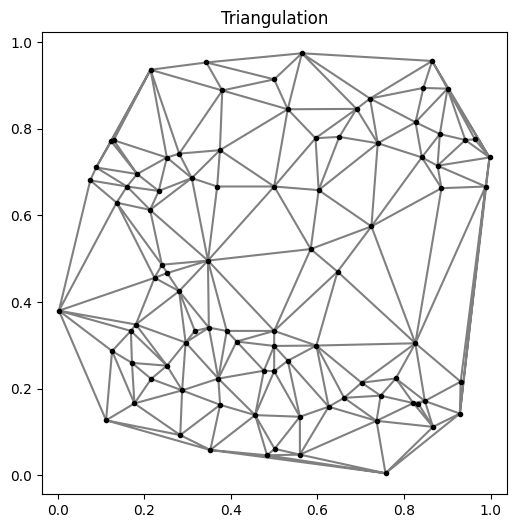

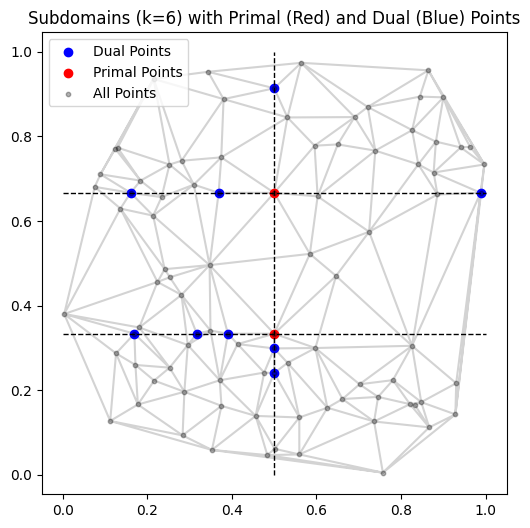

In [ ]:
mesh = Mesh2D(domain=((0, 1), (0, 1)))

# Random points + ensure border and primal points are present
mesh.get_points(n=80, ordered=False, add_border_points=True, k=6)

mesh.triangulate()
mesh.plot_triangulation()

mesh.divide_domain(k=6)
mesh.plot_subdomains_and_points()

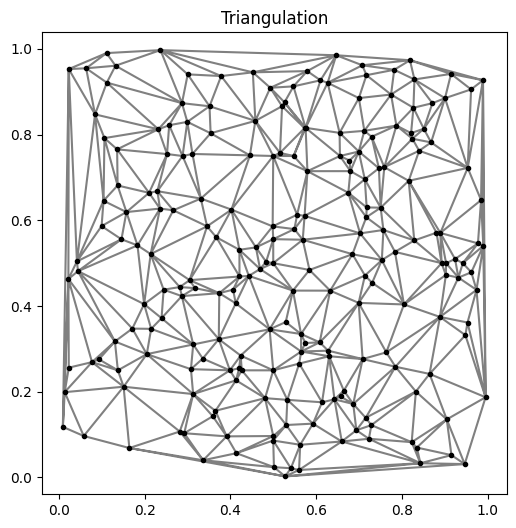

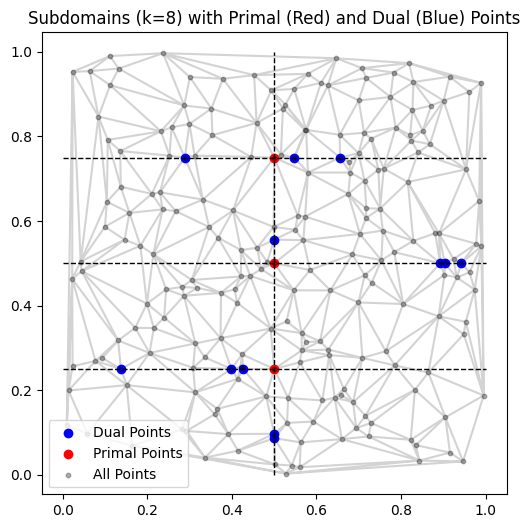

In [ ]:
mesh = Mesh2D(domain=((0, 1), (0, 1)))

# Random points + ensure border and primal points are present
mesh.get_points(n=200, ordered=False, add_border_points=True, k=8)

mesh.triangulate()
mesh.plot_triangulation()

mesh.divide_domain(k=8)
mesh.plot_subdomains_and_points()

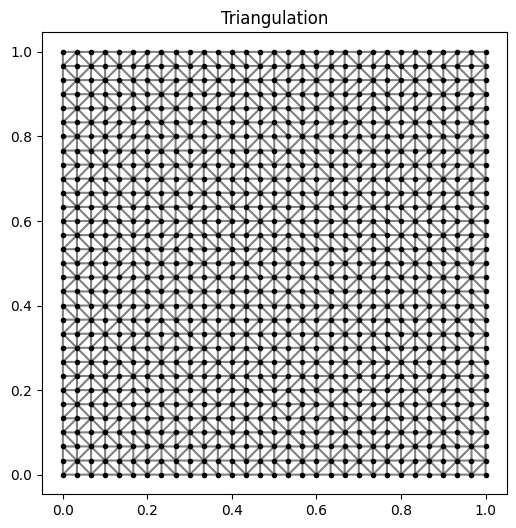

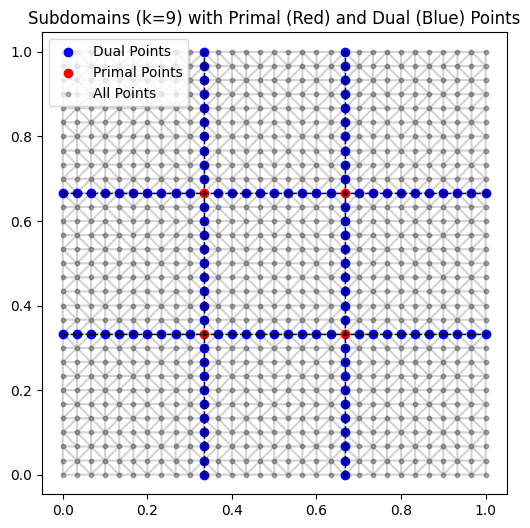

In [ ]:
mesh = Mesh2D(domain=((0, 1), (0, 1)))

# Random points + ensure border and primal points are present
mesh.get_points(n=1000, ordered=True, add_border_points=True, k=9)

mesh.triangulate()
mesh.plot_triangulation()

mesh.divide_domain(k=9)
mesh.plot_subdomains_and_points()